In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials
from EffectiveXGBoost import *

import xgbfir

path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Let us discuss techniques to improve the interpretability and performance of XGBoost models. 

- Individual Conditional Expectation (ICE) plots: These are visualization tools that show how a single feature affects the model's predictions for individual instances. They can help to understand complex interactions between features and provide insights into how the model is making its predictions.

- Partial Dependence Plots (PDP): These are another type of visualization tool that shows the average effect of a feature on the model's predictions. They can help to understand the global relationship between a feature and the target variable.

- Constrain XGBoost models: The chapter discusses techniques to prevent overfitting and improve generalization performance in XGBoost models. This can lead to more accurate and reliable predictions on new data.

## 20.1 ICE Plots

An ICE plot is a way to see how changing one piece of information (like the temperature outside) affects what a machine learning model predicts (like whether or not it will rain). Each line on the plot shows what the model predicts for one specific situation as you change that one piece of information. By looking at the lines, you can see how the model uses that information to make its predictions.

An ICE plot displays the model’s output for a fixed instance while incrementally changing one input feature’s value. Each line in the plot represents the predicted output for a particular instance as the input feature changes. By examining the shape and slope of each line, we can gain insights into how the model uses that input feature to make predictions.

ICE plots can provide more insights when interactions are present between features. For example, if there is an interaction between temperature and humidity, an ICE plot for temperature would show how the dependence of the prediction on temperature changes with different levels of humidity. ICE plots can also be used in conjunction with Partial Dependence Plots (PDPs), which show the average effect of a feature on the model's predictions. A PDP is essentially the average of all the lines in an ICE plot.

To create an ICE plot for a single row, you can follow these steps:

1. Pick one piece of information (input feature) that you want to analyze and decide on a range of values to use for it.
2. Keep all other pieces of information (input features) the same as they are for the specific situation (instance) you're looking at.
3. Change the value of the input feature you picked in step 1 to each value in the range you decided on.
4. For each value of the input feature, use the model to make a prediction for the specific situation you're looking at.
5. Make a graph with the input feature values on one axis and the predictions on the other axis. Each point on the graph will show one prediction.

By following these steps, you can create an ICE plot for a single row that shows how changing one piece of information affects what the model predicts. 


In [2]:
xgb_def = xgb.XGBClassifier(random_state=42)
xgb_def.fit(X_train, y_train)
xgb_def.score(X_test, y_test)

0.7458563535911602

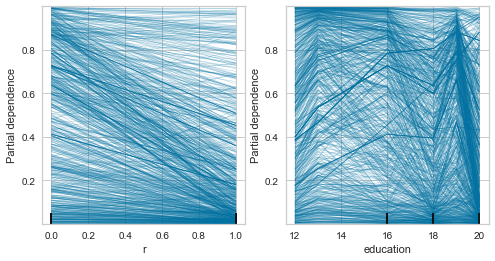

In [3]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'], 
                                        kind='individual', ax=axes)

One technique to help make the visualizations more clear is to have them all start at the
same value on the left-hand side. We can do that with the `'centered=True'` parameter.

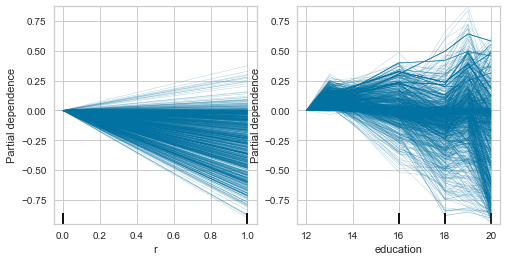

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, 
                                        features=['r', 'education'], 
                                        centered=True, kind='individual', ax=axes);

A histogram can provide insight into the density of data, showing where there is more or less data. Locations with more data would tend to have better predictions because the model has more information to work with. In the case of education, for example, if there are not many examples of respondents with less than 14 years of education, there would be more uncertainty about predictions for those individuals.

Here's a breakdown of the code to be used:

```python
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
```
This line creates a figure and two subplots (axes) arranged in two columns using the `subplots` function from the `matplotlib.pyplot` module. The `figsize` parameter sets the width and height of the figure in inches.

```python
ax_h0 = axes[0].twinx()
```
This line creates a new `Axes` object that shares the x-axis with the first subplot (`axes[0]`) using the `twinx` method. This new `Axes` object is assigned to the variable `ax_h0`.

```python
ax_h0.hist(X_train.r, zorder=0)
```
This line creates a histogram on the `ax_h0` subplot using the `hist` method. The data for the histogram comes from the `r` column of the `X_train` DataFrame. The `zorder` parameter sets the order in which the histogram is drawn relative to other elements on the subplot.

```python
ax_h1 = axes[1].twinx()
```
This line creates a new `Axes` object that shares the x-axis with the second subplot (`axes[1]`) using the `twinx` method. This new `Axes` object is assigned to the variable `ax_h1`.

```python
ax_h1.hist(X_train.education, zorder=0)
```
This line creates a histogram on the `ax_h1` subplot using the `hist` method. The data for the histogram comes from the `education` column of the `X_train` DataFrame. The `zorder` parameter sets the order in which the histogram is drawn relative to other elements on the subplot.

```python
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True,
ice_lines_kw={'zorder':10},
kind='individual', ax=axes)
```
This line uses the `from_estimator` method of the `PartialDependenceDisplay` class to create partial dependence plots for an XGBoost model (`xgb_def`) fitted on training data (`X_train`). The partial dependence plots are created for two features: `'r'` and `'education'`. The `centered` parameter specifies whether to center the partial dependence plots. The `ice_lines_kw` parameter sets additional keyword arguments for drawing ICE lines (in this case, setting their z-order). The `kind` parameter specifies whether to plot individual ICE lines or an average partial dependence line. The `ax` parameter specifies which subplots to use for drawing the partial dependence plots.

```python
fig.tight_layout()
```
This line adjusts the padding between and around subplots using the `tight_layout` method of the figure object (`fig`) to prevent overlapping.

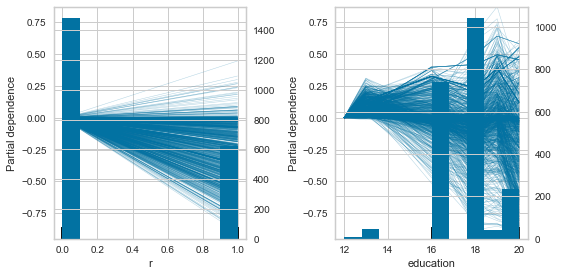

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

ax_h0 = axes[0].twinx()
ax_h0.hist(X_train.r, zorder=0)
ax_h1 = axes[1].twinx()
ax_h1.hist(X_train.education, zorder=0)
PartialDependenceDisplay.from_estimator(xgb_def, 
                                        X_train, features=['r', 'education'],centered=True,
                                        ice_lines_kw={'zorder':10},kind='individual', 
                                        ax=axes)
fig.tight_layout()

Sure! Here's a line-by-line breakdown of the `quantile_ice` function you provided:

```python
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True, 
                 add_hist=False, title='', val_limit=10, ax=None):
```
This line defines the `quantile_ice` function and its parameters. The required parameters are `clf`, `X`, and `col`, which represent the classifier, the dataset, and the name of the column to plot ICE curves for, respectively. The other parameters are optional and have default values. They control various aspects of the ICE curve calculation and plotting.

```python
probs = clf.predict_proba(X)
```
This line calculates the predicted probabilities for each instance in the dataset `X` using the `predict_proba` method of the classifier `clf`. The resulting array of probabilities is assigned to the variable `probs`.

```python
df = (X
        .assign(probs=probs[:,-1], 
                p_bin=lambda df_:pd.qcut(df_.probs, q=q,
                                         labels=[f'q{n}' for n in range(1,q+1)])
        )
        )
```
These lines create a new DataFrame named `df` by adding two new columns to the input dataset `X`. The first new column is named `probs` and contains the predicted probabilities calculated in the previous line. The second new column is named `p_bin` and contains labels indicating which quantile each instance belongs to based on its predicted probability. The number of quantiles is determined by the `q` parameter of the function.

```python
groups = df.groupby('p_bin')
```
This line groups the instances in the `df` DataFrame by their quantile (as indicated by the `p_bin` column) using the `groupby` method. The resulting `DataFrameGroupBy` object is assigned to the variable `groups`.

```python
vals = X.loc[:,col].unique()
```
This line extracts the unique values of the specified column (`col`) from the input dataset (`X`) using the `unique` method. The resulting array of unique values is assigned to the variable `vals`.

```python
if len(vals) > val_limit:
        vals = np.linspace(min(vals), max(vals), num=val_limit)
```
These lines check if the number of unique values in `vals` is greater than a specified limit (`val_limit`). If it is, a new array of equally-spaced values between the minimum and maximum values in `vals` is created using the `linspace` function from the NumPy module. This new array has a length equal to `val_limit`. The resulting array is assigned to the variable `vals`.

```python
res = []
```
This line initializes an empty list named `res`. This list will be used to store modified versions of instances from each quantile.

```python
for name,g in groups:
```
This line starts a loop over each group (quantile) in the `groups` DataFrameGroupBy object. On each iteration of the loop, the group name (`name`) and group DataFrame (`g`) are assigned to their respective variables.

```python
for val in vals:
```
This line starts a nested loop over each value in the `vals` array. On each iteration of this inner loop, one value from the array is assigned to the variable `val`.

```python
this_X = g.loc[:,X.columns].assign(**{col:val})
```
This line creates a modified version of each instance in group `g` by setting the value of column `col` to `val`. The resulting DataFrame is assigned to variable `this_X`.

```python
q_prob = clf.predict_proba(this_X)[:,-1]
```
This line calculates predicted probabilities for each modified instance in DataFrame `this_X` using classifier's (`clf`) method predict_proba. The resulting array of probabilities is assigned to variable q_prob.

```python
res.append(this_X.assign(prob=q_prob, group=name))
```
This line adds two new columns to DataFrame this_X: 'prob' containing predicted probabilities calculated in previous step and 'group' containing current group name. Then it appends modified DataFrame this_X with two new columns to list res.

```python
results = pd.concat(res, axis='index')
```
After both loops have completed, this line concatenates all DataFrames stored in list res into one DataFrame results using pandas concat function.

```python
if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))
```
These lines check if an Axes object was passed as an argument to function (ax parameter). If not it creates a new figure and Axes object using



```python
if add_hist:
        back_ax = ax.twinx()
        back_ax.hist(X[col], density=True, alpha=.2)
```
These lines check if the `add_hist` parameter is set to `True`. If it is, a histogram showing the distribution of values for the specified column (`col`) in the input dataset (`X`) is plotted on a secondary y-axis. The `twinx` method is used to create a new Axes object that shares the x-axis with the original Axes object (`ax`).

```python
for name, g in results.groupby('group'):
        g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
```
These lines group the `results` DataFrame by quantile (as indicated by the `group` column) using the `groupby` method. For each group, the average predicted probability for each value of column `col` is calculated using the `mean` method. The resulting Series is then plotted on the specified Axes object (`ax`) using the `plot` method.

```python
if legend:
        ax.legend()
```
This line checks if the `legend` parameter is set to `True`. If it is, a legend is added to the plot using the `legend` method of the Axes object (`ax`).

```python
if title:
        ax.set_title(title)
```
This line checks if a title was specified (i.e., if the `title` parameter is not an empty string). If it was, the title of the plot is set to the specified title using the `set_title` method of the Axes object (`ax`).

```python
return results
```
This line returns the `results` DataFrame as the output of the function.

In summary, these remaining lines of code plot quantile-based ICE curves for each value of column `col`, add a histogram and legend to the plot if requested, and return a DataFrame containing modified versions of instances from each quantile along with their predicted probabilities.


In [6]:
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True, 
                 add_hist=False, title='', val_limit=10, ax=None):
    """
    Generate an ICE plot for a binary classifier's predicted probabilities split
    by quantiles.
    Parameters:
    ----------
    clf : binary classifier
    A binary classifier with a `predict_proba` method.
    X : DataFrame
    Feature matrix to predict on with shape (n_samples, n_features).
    col : str
    Name of column in `X` to plot against the quantiles of predicted probabilities.
    center : bool, default=True
    Whether to center the plot on 0.5.
    q : int, default=10
    Number of quantiles to split the predicted probabilities into.
    color : str or array-like, default='k'
    Color(s) of the lines in the plot.
    alpha : float, default=0.5
    Opacity of the lines in the plot.
    legend : bool, default=True
    Whether to show the plot legend.
    add_hist : bool, default=False
    Whether to add a histogram of the `col` variable to the plot.
    title : str, default=''
    Title of the plot.
    val_limit : num, default=10
    Maximum number of values to test for col.
    ax : Matplotlib Axis, deafault=None
    Axis to plot on.

    Returns:
    -------
    results : DataFrame
    A DataFrame with the same columns as `X`, as well as a `prob` column with
    the predicted probabilities of `clf` for each row in `X`, and a `group`
    column indicating which quantile group the row belongs to.
    """
    probs = clf.predict_proba(X)
    df = (X
        .assign(probs=probs[:,-1], 
                p_bin=lambda df_:pd.qcut(df_.probs, q=q,
                                         labels=[f'q{n}' for n in range(1,q+1)])
        )
        )
    groups = df.groupby('p_bin')
    
    vals = X.loc[:,col].unique()
    if len(vals) > val_limit:
        vals = np.linspace(min(vals), max(vals), num=val_limit)
    res = []
    for name,g in groups:
        for val in vals:
            this_X = g.loc[:,X.columns].assign(**{col:val})
            q_prob = clf.predict_proba(this_X)[:,-1]
            res.append(this_X.assign(prob=q_prob, group=name))
    results = pd.concat(res, axis='index')
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))
    if add_hist:
        back_ax = ax.twinx()
        back_ax.hist(X[col], density=True, alpha=.2)
    for name, g in results.groupby('group'):
        g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
    if legend:
        ax.legend()
    if title:
        ax.set_title(title)
    return results

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,prob,group
3110,40,18.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0.005568,q1
3798,35,18.0,4.0,125000,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0.020992,q1
18640,18,18.0,2.0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0.001421,q1
2621,25,18.0,1.0,125000,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0.007570,q1
4035,30,18.0,2.0,125000,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0.001280,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,35,19.0,10.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.918584,q10
21649,35,19.0,15.0,10000,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.933382,q10
4196,60,19.0,20.0,100000,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0.983405,q10
16608,25,19.0,2.0,10000,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0.914242,q10


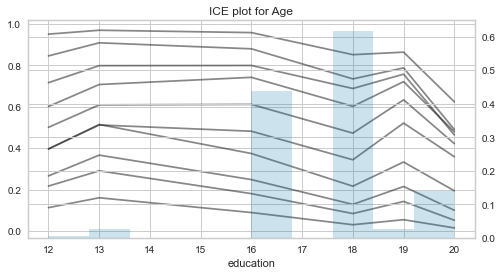

In [7]:
fig, ax = plt.subplots(figsize=(8,4))

quantile_ice(xgb_def, X_train, 'education', q=10, legend=False, add_hist=True, ax=ax,
             title='ICE plot for Age')

## 20.2 ICE Plots with SHAP

ICE plots are a tool for creating Individual Conditional Expectation plots. These plots can be created using the SHAP library, which also allows for the creation of histograms. The model parameter for creating an ICE plot using SHAP needs to be a function that returns probabilities when given rows of data. The rows for which ice lines are drawn can be specified using the 'data' parameter. The 'npoints' parameter must be set to the number of unique values for a column.

An additional fact about ICE plots is that they can reveal how the effect of a feature on the predicted outcome varies across different instances. For example, an ICE plot could show how the predicted probability of cancer changes with age for different women.


Text(0.5, 1.0, 'ICE plot (from SHAP)')

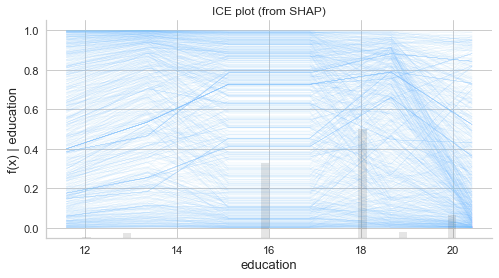

In [14]:
import shap

fig, ax = plt.subplots(figsize=(8,4))

shap.partial_dependence_plot(ind='education',
    model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=True,
    npoints=(X_train.education.nunique()),
    pd_linewidth=0, show=False, ax=ax)
ax.set_title('ICE plot (from SHAP)')

In [17]:
# import shap
# fig, ax = plt.subplots(figsize=(8,4))
# col = 'years_exp'
# shap.plots.partial_dependence_plot(ind=col,
# model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
# data=X_train.iloc[0:1000], ice=False,
# npoints=(X_train[col].nunique()),
# pd_linewidth=2, show=False, ax=ax)
# ax.set_title('PDP plot (from SHAP)')


Text(0.5, 1.0, 'PDP plot (from SHAP)')

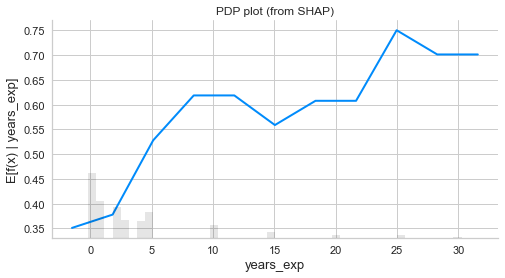

In [18]:
import shap
fig, ax = plt.subplots(figsize=(8,4))
col = 'years_exp'
shap.partial_dependence_plot(ind=col,
    model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=False,
    npoints=(X_train[col].nunique()),
    pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP)')


Text(0.5, 1.0, 'PDP plot (from SHAP) with ICE Plots')

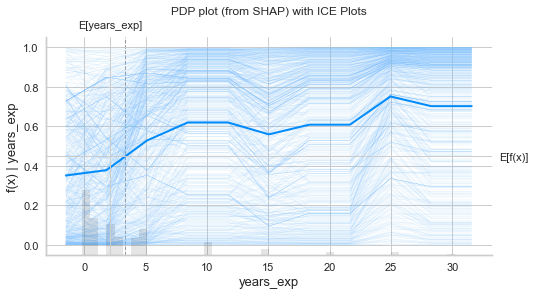

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
col = 'years_exp'
shap.partial_dependence_plot(ind=col, model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=True,
    npoints=(X_train[col].nunique()),
    model_expected_value=True,
    feature_expected_value=True,
    pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP) with ICE Plots')

This code creates a horizontal bar plot of the Spearman correlation between the features in the `X_test` DataFrame and the target variable `y_test`. Here is an explanation of each line of code:

1. `fig, ax = plt.subplots(figsize=(8,4))`: This line creates a new figure and axes object for the plot using the `subplots` function from the `matplotlib.pyplot` module. The `figsize` parameter specifies the size of the figure in inches.

2. `(X_test`: This line opens a new block of code that operates on the `X_test` DataFrame.

3. `.assign(target=y_test)`: This line adds a new column to the DataFrame called `target` and assigns it the values from `y_test`.

4. `.corr(method='spearman')`: This line calculates the pairwise Spearman correlation between all columns in the DataFrame.

5. `.iloc[:-1]`: This line selects all rows of the DataFrame except for the last one.

6. `.loc[:,'target']`: This line selects the `target` column from the DataFrame.

7. `.sort_values(key=np.abs)`: This line sorts the values in the `target` column by their absolute value.

8. `.plot.barh(title='Spearman Correlation with Target', ax=ax)`: This line creates a horizontal bar plot of the sorted values in the `target` column using the `barh` method of the `plot` accessor. The `title` parameter specifies the title of the plot and the `ax` parameter specifies the axes object on which to draw the plot.

9. `)`: This line closes the block of code that operates on the `X_test` DataFrame.

Overall, this code calculates the Spearman correlation between each feature in `X_test` and the target variable `y_test`, sorts the correlations by their absolute value, and creates a horizontal bar plot of the sorted correlations.

<AxesSubplot:title={'center':'Spearman Correlation with Target'}>

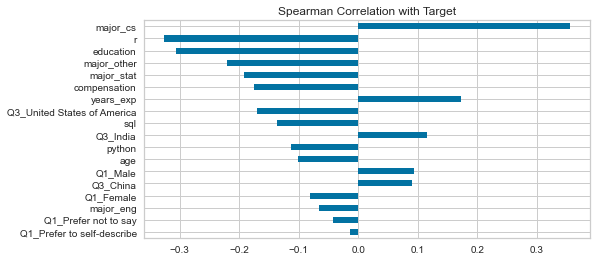

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
(X_test
.assign(target=y_test)
.corr(method='spearman')
.iloc[:-1]
 .loc[:,'target']
.sort_values(key=np.abs)
.plot.barh(title='Spearman Correlation with Target', ax=ax)
)

In [22]:
print(X_train
 .assign(target=y_train)
 .groupby('education')
 .mean()
 .loc[:, ['age', 'years_exp', 'target']]
 )

                 age  years_exp    target
education                                
12.0       30.428571   2.857143  0.714286
13.0       30.369565   6.760870  0.652174
16.0       25.720867   2.849593  0.605691
18.0       28.913628   3.225528  0.393474
19.0       27.642857   4.166667  0.571429
20.0       35.310638   4.834043  0.174468


In [23]:
X_train.education.value_counts()

18.0    1042
16.0     738
20.0     235
13.0      46
19.0      42
12.0       7
Name: education, dtype: int64

In [24]:
print(raw
 .query('Q3.isin(["United States of America", "China", "India"]) '
        'and Q6.isin(["Data Scientist", "Software Engineer"])')
 .query('Q4 == "Professional degree"')
 .pipe(lambda df_:pd.crosstab(index=df_.Q5, columns=df_.Q6))
 )

Q6                                                  Data Scientist  \
Q5                                                                   
A business discipline (accounting, economics, f...               0   
Computer science (software engineering, etc.)                   12   
Engineering (non-computer focused)                               6   
Humanities (history, literature, philosophy, etc.)               2   
I never declared a major                                         0   
Mathematics or statistics                                        2   
Other                                                            2   
Physics or astronomy                                             2   

Q6                                                  Software Engineer  
Q5                                                                     
A business discipline (accounting, economics, f...                  1  
Computer science (software engineering, etc.)                      19  
Engineering

Monotonic constraints can be added to ensure that the model adheres to a particular relationship between a feature and the outcome. This can improve the accuracy and interpretability of the model and reduce overfitting. The text provides an example where monotonic constraints are added to the `education` and `years_exp` columns based on their relationships with the outcome as observed in PDP and ICE plots.

In [25]:
xgb_const = xgb.XGBClassifier(random_state=42,
                              monotone_constraints={'years_exp':1, 'education':-1})
xgb_const.fit(X_train, y_train)
xgb_const.score(X_test, y_test)

0.7546961325966851

In [26]:
small_cols = ['age', 'education', 'years_exp', 'compensation', 'python', 'r', 'sql',
    #'Q1_Male', 'Q1_Female', 'Q1_Prefer not to say',
    #'Q1_Prefer to self-describe',
    'Q3_United States of America', 'Q3_India',
    'Q3_China', 'major_cs', 'major_other', 'major_eng', 'major_stat']
xgb_const2 = xgb.XGBClassifier(random_state=42,
    monotone_constraints={'years_exp':1, 'education':-1})
xgb_const2.fit(X_train[small_cols], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan,
              monotone_constraints={'education': -1, 'years_exp': 1},
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [27]:
xgb_const2.score(X_test[small_cols], y_test)

0.7569060773480663

<AxesSubplot:>

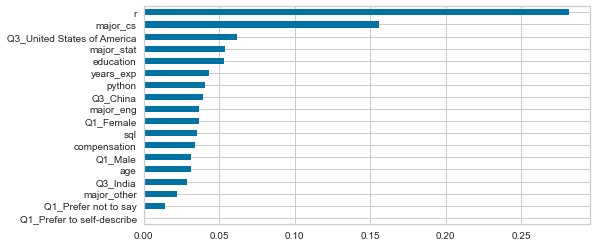

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

<AxesSubplot:>

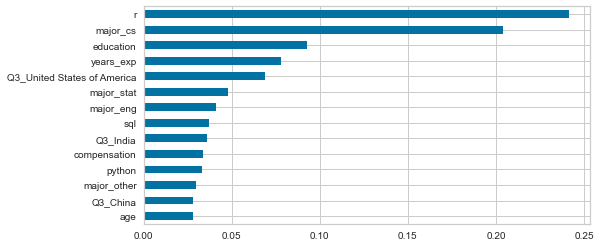

In [29]:
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_const2.feature_importances_, index=small_cols)
.sort_values()
.plot.barh(ax=ax)
)

## 20.6 Calibrating a Model

Calibration refers to adjusting a model’s output to better align with the actual probabilities of the target variable. If we want to use the probabilities (from .predict_proba) and not just the target, we will want to calibrate our model. With XGBoost, the probability output often does not correspond to the actual probabilities of the target variable. XGBoost models tend to produce predicted probabilities biased towards the ends of the probability range, meaning they often overestimate or underestimate the actual probabilities. This will lead to poor performance on tasks that require accurate probability estimates, such as ranking, threshold selection, and decision-making.

Calibrating an XGBoost model involves post-processing the predicted probabilities of the model using a calibration method, such as Platt scaling or isotonic regression. These methods map the model’s predicted probabilities to calibrated probabilities that better align with the actual probabilities of the target variable. Calibration is important because it gives insight into model uncertainty, which can be later communicated to end-users or used in further processing of the model outputs.

In [30]:
from sklearn.calibration import CalibratedClassifierCV
xgb_cal = CalibratedClassifierCV(xgb_def, method='sigmoid', cv='prefit')
xgb_cal.fit(X_test, y_test)
xgb_cal_iso = CalibratedClassifierCV(xgb_def, method='isotonic', cv='prefit')
xgb_cal_iso.fit(X_test, y_test)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None, gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.300000012,
                                                    max_bin=256,
                                                    max_cat_to_onehot=4,
                                                    max_delta_step=0,
                                                    max_depth=6, max_leaves=0,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints='()',
                                                    n_estimators=100, n_jobs=0,
                                                    num_parallel_tree=1,
                                                    predictor='auto',
                                                    random_state=42,
                                                    reg_alpha=0, reg_lambda=1, ...),
                       cv='prefit', method='isotonic')

## 20.7 Calibration Curves

A calibration curve is a graphical representation of the relationship between predicted probabilities and the actual frequencies of events in a binary classification problem. The curve plots the predicted probabilities against the observed frequencies of the positive class for different probability thresholds. The calibration curve visually assesses how well a classification model’s predicted probabilities match the true probabilities of the events of interest. A well-calibrated model should have predicted probabilities that match the actual probabilities of the events, meaning that the calibration curve should be close to the diagonal line. If the calibration curve deviates from the diagonal line, it suggests that the model’s predicted probabilities are either overconfident or underconfident.

Calibration curves can be used to diagnose how calibrated a model is and methods can be used to better calibrate predictions for a problem. Often, this can lead to better quality predictions, depending on how the skill of the model is evaluated ¹. In scikit-learn, you can use `calibration_curve()` function to compute true and predicted probabilities for a calibration curve.

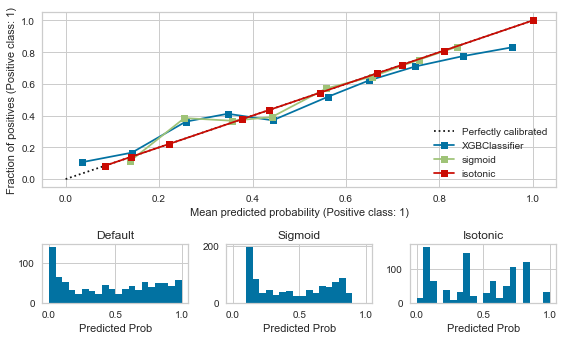

In [31]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,6))
gs = GridSpec(4, 3)
axes = fig.add_subplot(gs[:2, :3])
display = CalibrationDisplay.from_estimator(xgb_def, X_test, y_test,
                                            n_bins=10, ax=axes)
disp_cal = CalibrationDisplay.from_estimator(xgb_cal, X_test, y_test, 
                                             n_bins=10,ax=axes, name='sigmoid')
disp_cal_iso = CalibrationDisplay.from_estimator(xgb_cal_iso, X_test, y_test, 
                                                 n_bins=10, ax=axes, name='isotonic')
row = 2
col = 0
ax = fig.add_subplot(gs[row, col])
ax.hist(display.y_prob, range=(0,1), bins=20)
ax.set(title='Default', xlabel='Predicted Prob')
ax2 = fig.add_subplot(gs[row, 1])
ax2.hist(disp_cal.y_prob, range=(0,1), bins=20)
ax2.set(title='Sigmoid', xlabel='Predicted Prob')
ax3 = fig.add_subplot(gs[row, 2])
ax3.hist(disp_cal_iso.y_prob, range=(0,1), bins=20)
ax3.set(title='Isotonic', xlabel='Predicted Prob')
fig.tight_layout()

The text suggests that the default model does a respectable job in tracking the diagonal of the calibration curve. However, the calibrated models appear to track the diagonal better. The histograms show the distribution of the default model and the calibrated models. When looking at the score of the calibrated models, it appears that they perform slightly better in terms of accuracy.

In [32]:
xgb_cal.score(X_test, y_test)

0.7480662983425415

In [33]:
xgb_cal_iso.score(X_test, y_test)

0.7491712707182321

In [34]:
xgb_def.score(X_test, y_test)

0.7458563535911602

## 20.8 Summary

1. ICE (Individual Conditional Expectation) and PDP (Partial Dependence) plots can be used to identify non-linear relationships between features and the predicted outcome in an XGBoost model by visualizing and analyzing the interaction between the target response and a set of input features of interest.

2. ICE and PDP plots can be used to compare the effects of different features on the predicted outcome in an XGBoost model by showing the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features ¹.

3. Yes, ICE and PDP plots can visualize interactions between features in an XGBoost model. For example, two-variable PDPs show the dependence of the target response on joint values of two input features.

4. Monotonic constraints in XGBoost are used to specify that the relationship between a feature and the predicted outcome should be either non-increasing or non-decreasing. This can help improve the interpretability of the model and prevent unrealistic predictions.

5. Monotonic constraints can be specified for individual features in an XGBoost model by setting the 'monotone_constraints' parameter when creating an XGBoost model. The parameter takes a tuple of values, where each value corresponds to a feature and specifies whether the relationship between that feature and the predicted outcome should be non-increasing (-1), non-decreasing (1), or unconstrained (0).

6. Some potential benefits of adding monotonic constraints to an XGBoost model include improved interpretability, prevention of unrealistic predictions, and increased trust in the model's predictions. Monotonic constraints can be particularly useful when there is prior knowledge or domain expertise indicating that certain relationships between features and the predicted outcome should be monotonic.

7. The calibration curve can be used to assess the calibration of an XGBoost model’s predicted probabilities by plotting the observed proportion of positive outcomes against the predicted probability for each bin of predicted probabilities. A well-calibrated model will have a calibration curve that closely follows the diagonal line.

8. Calibration techniques can help improve the reliability of an XGBoost model’s probabilistic predictions in practical applications by adjusting the predicted probabilities so that they better match the observed proportions of positive outcomes. This can help improve decision-making based on the model's predictions.
